## **Aplicação de XGBoost Regression**
Neste notebook será aplicado o modelo XGBoost Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from src.features import add_calendar_features
from src.features import add_lagged_features
from feature_engine.creation import CyclicalFeatures
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

## **Feature Engineering**

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste
kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'feriado_lag-3', 'feriado_lag-2',
       'feriado_lag-1', 'feriado_lag1', 'feriado_lag2', 'feriado_lag3',
       'month_end_lag-3', 'month_end_lag-2', 'month_end_lag-1',
       'month_end_lag1', 'month_end_lag2', 'month_end_lag3'],
      dtype='object')

In [7]:
features_to_encode = [
    "day",
    "week",
    "day_of_week",
    "month",
    "quarter",
]
max_values = {
    "day" : 31,
    "week" : 53,
    "day_of_week" : 6,
    "month" : 12,
    "quarter" : 4,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)


In [8]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'feriado_lag-3', 'feriado_lag-2',
       'feriado_lag-1', 'feriado_lag1', 'feriado_lag2', 'feriado_lag3',
       'month_end_lag-3', 'month_end_lag-2', 'month_end_lag-1',
       'month_end_lag1', 'month_end_lag2', 'month_end_lag3', 'day_sin',
       'day_cos', 'week_sin', 'week_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos'],
      dtype='object')

## **XGBoost Regression**

In [9]:
def dt_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo XGBoost Regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query(
        "unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = DecisionTreeRegressor()
    
    m.fit(X=train.iloc[:,3:], y=train.y)
    
    fcst_df['y_pred'] = m.predict(fcst_df.iloc[:,3:])

    return fcst_df

In [10]:
# aplicando modelo para cada série
dt_fcst = (
    features_train_df
        .groupby("unique_id")
        .apply(dt_regressor)
        .reset_index(drop=True)
)

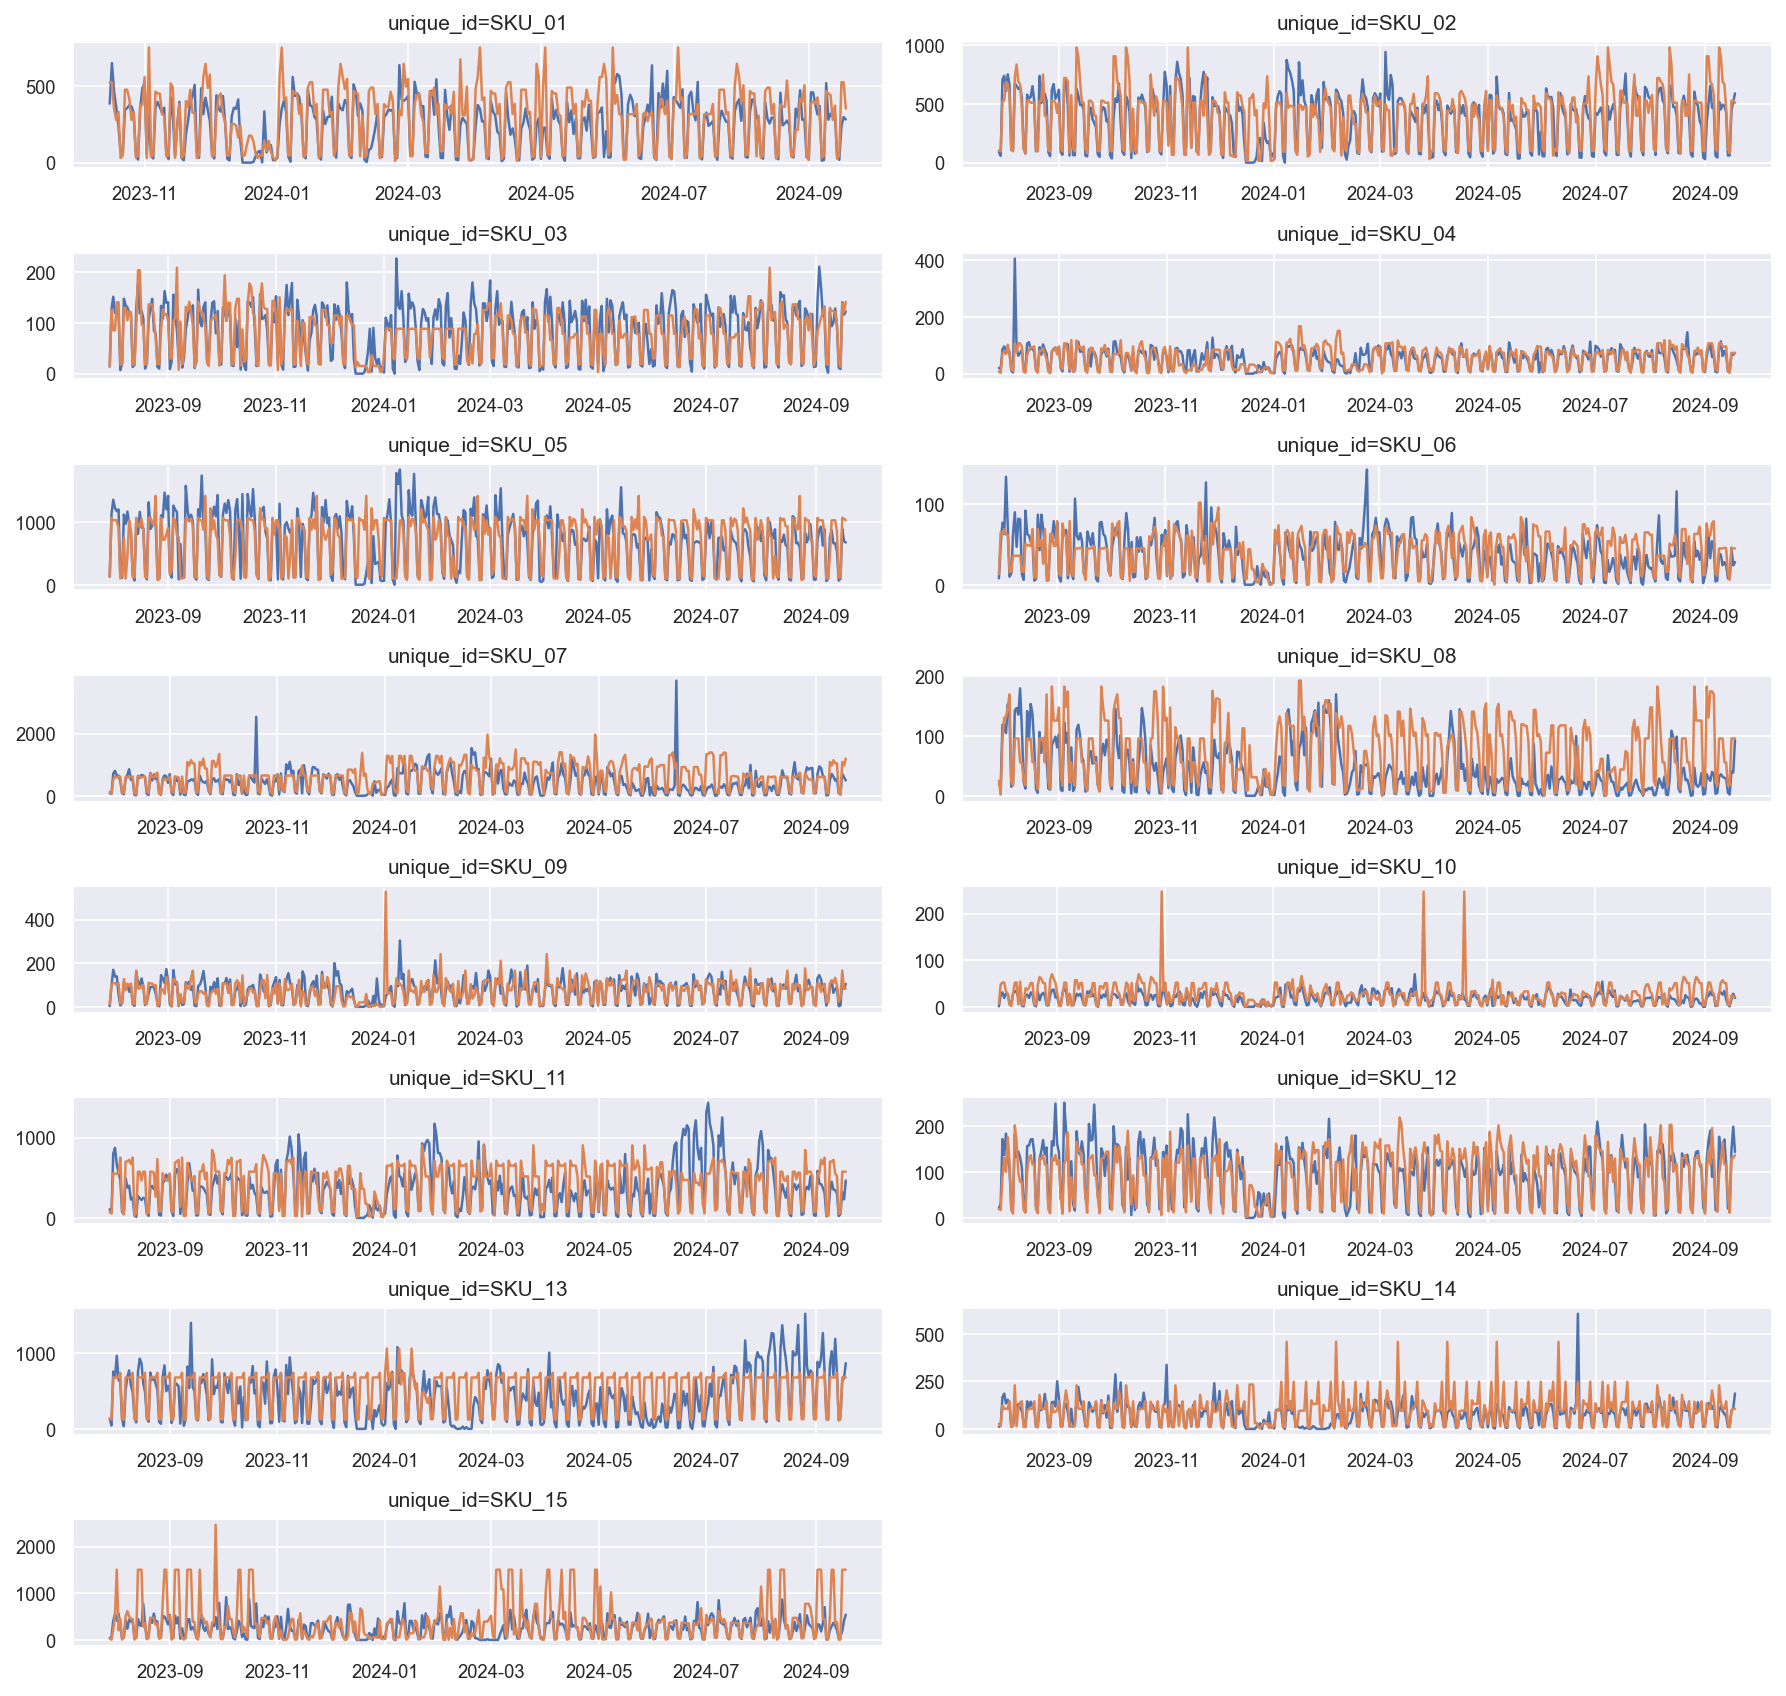

In [11]:
fig = plot_time_series(df=dt_fcst, data_cols=['y', 'y_pred'])

In [14]:
rf_eval = Evaluation(dt_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Decision Tree [+Lags +Fourier]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,97.43,19495.90,139.63,0.31
SKU_02,107.03,26247.81,162.01,0.50
SKU_03,24.39,1119.27,33.46,0.60
SKU_04,17.41,839.81,28.98,0.42
SKU_05,228.75,118667.15,344.48,0.44
SKU_06,15.38,456.45,21.36,0.35
SKU_07,305.39,200579.24,447.86,-0.40
SKU_08,42.13,3223.38,56.77,-0.92
SKU_09,27.91,2066.76,45.46,0.22
SKU_10,13.50,632.37,25.15,-2.96


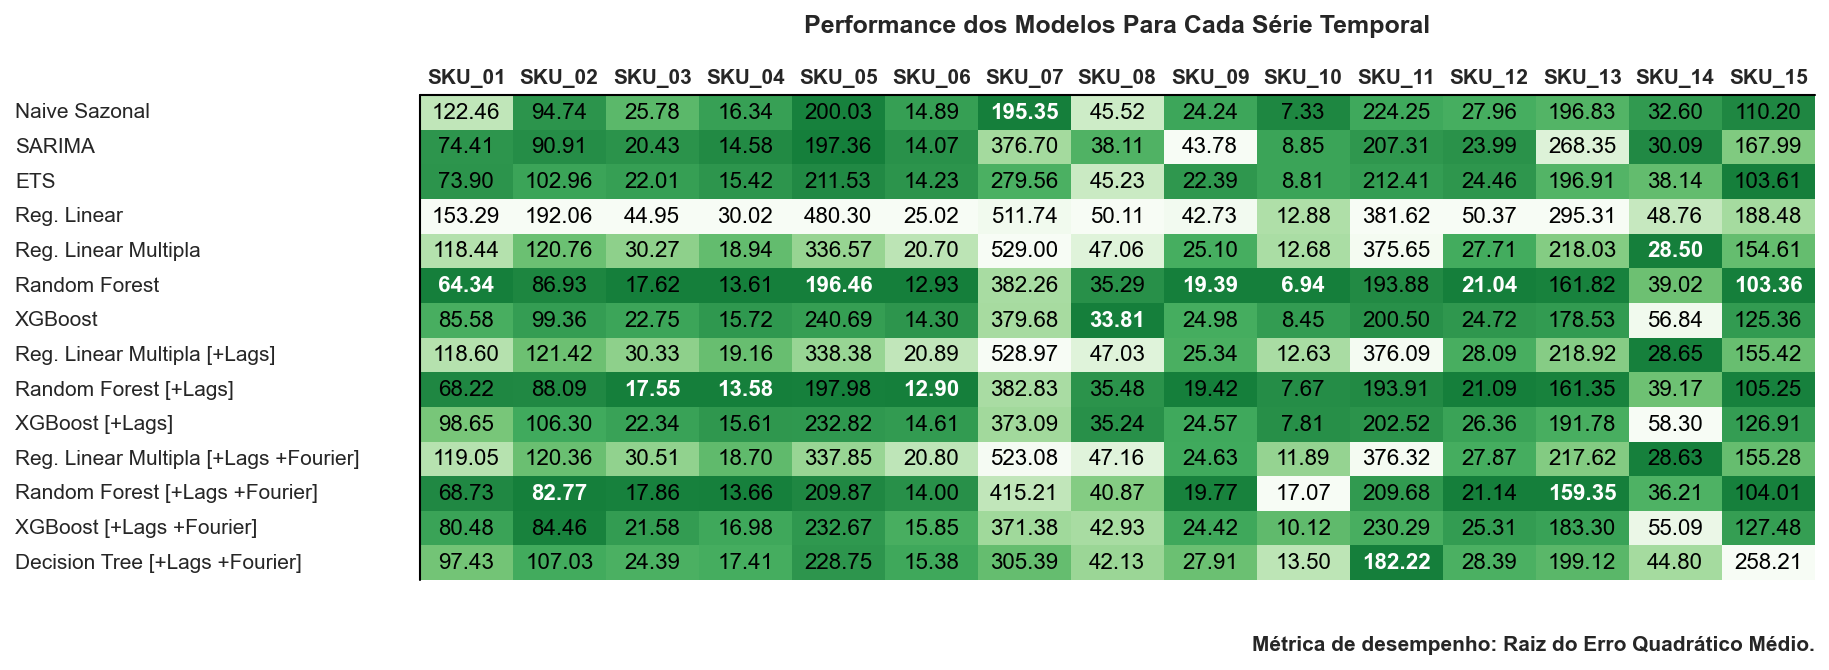

In [15]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('mae','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 4.2))